In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

import os
import torch
from torch import nn
from torch import Tensor
from torch import optim
import torch.nn.functional as F

import matplotlib.font_manager as fm
from matplotlib import rc
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option("display.width", 600)
from sklearn.preprocessing import StandardScaler
import xlrd
import seaborn as sns
error_bad_lines=False

import glob

# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt', 'rc']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [4]:
class InputAttentionEncoder(nn.Module):
    def __init__(self, N, M, T, stateful=False):
        """
        :param: N: int
            number of time serieses
        :param: M:
            number of LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.N = N
        self.M = M
        self.T = T
        
        self.encoder_lstm = nn.LSTMCell(input_size=self.N, hidden_size=self.M)
        
        self.W_e = nn.Linear(2*self.M, self.T)
        self.U_e = nn.Linear(self.T, self.T, bias=False)
        self.v_e = nn.Linear(self.T, 1, bias=False)
    
    def forward(self, inputs):
        encoded_inputs = torch.zeros((inputs.size(0), self.T, self.M)).cuda()
        
        h_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        s_tm1 = torch.zeros((inputs.size(0), self.M)).cuda()
        
        for t in range(self.T):
            h_c_concat = torch.cat((h_tm1, s_tm1), dim=1)
            
            x = self.W_e(h_c_concat).unsqueeze_(1).repeat(1, self.N, 1)
            y = self.U_e(inputs.permute(0, 2, 1))
            z = torch.tanh(x + y)
            e_k_t = torch.squeeze(self.v_e(z))
        
            alpha_k_t = F.softmax(e_k_t, dim=1)
            
            weighted_inputs = alpha_k_t * inputs[:, t, :] 
    
            h_tm1, s_tm1 = self.encoder_lstm(weighted_inputs, (h_tm1, s_tm1))
            
            encoded_inputs[:, t, :] = h_tm1
        return encoded_inputs

In [5]:
class TemporalAttentionDecoder(nn.Module):
    def __init__(self, M, P, T, stateful=False):
        """
        :param: M: int
            number of encoder LSTM units
        :param: P:
            number of deocder LSTM units
        :param: T:
            number of timesteps
        :param: stateful:
            decides whether to initialize cell state of new time window with values of the last cell state
            of previous time window or to initialize it with zeros
        """
        super(self.__class__, self).__init__()
        self.M = M
        self.P = P
        self.T = T
        self.stateful = stateful
        
        self.decoder_lstm = nn.LSTMCell(input_size=1, hidden_size=self.P)
        
        self.W_d = nn.Linear(2*self.P, self.M)
        self.U_d = nn.Linear(self.M, self.M, bias=False)
        self.v_d = nn.Linear(self.M, 1, bias = False)
        
        self.w_tilda = nn.Linear(self.M + 1, 1)
        
        self.W_y = nn.Linear(self.P + self.M, self.P)
        self.v_y = nn.Linear(self.P, 1)
        
    def forward(self, encoded_inputs, y):
        
        d_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        s_prime_tm1 = torch.zeros((encoded_inputs.size(0), self.P)).cuda()
        for t in range(self.T):
            d_s_prime_concat = torch.cat((d_tm1, s_prime_tm1), dim=1)
            x1 = self.W_d(d_s_prime_concat).unsqueeze_(1).repeat(1, encoded_inputs.shape[1], 1)
            y1 = self.U_d(encoded_inputs)
            z1 = torch.tanh(x1 + y1)
            l_i_t = self.v_d(z1)
            
            beta_i_t = F.softmax(l_i_t, dim=1)
            
            c_t = torch.sum(beta_i_t * encoded_inputs, dim=1)
            
            y_c_concat = torch.cat((c_t, y[:, t, :]), dim=1)

            y_tilda_t = self.w_tilda(y_c_concat)

            d_tm1, s_prime_tm1 = self.decoder_lstm(y_tilda_t, (d_tm1, s_prime_tm1))
        
        d_c_concat = torch.cat((d_tm1, c_t), dim=1)

        y_Tp1 = self.v_y(self.W_y(d_c_concat))
        return y_Tp1

In [6]:
class DARNN(nn.Module):
    def __init__(self, N, M, P, T, stateful_encoder=False, stateful_decoder=False):
        super(self.__class__, self).__init__()
        self.encoder = InputAttentionEncoder(N, M, T, stateful_encoder).cuda()
        self.decoder = TemporalAttentionDecoder(M, P, T, stateful_decoder).cuda()
    def forward(self, X_history, y_history):
        out = self.decoder(self.encoder(X_history), y_history)
        return out

In [7]:
data_list = glob.glob('/content/drive/MyDrive/빅콘2021/Data/DARNN/*_minmax.csv')
len(data_list)

42

In [10]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
seed_everything(42)

Saving...
Iter:  0 train:  0.24443616589677686 val:  0.36216728989009006
mse:  0.13116513 mae:  0.35517746
Saving...
Iter:  1 train:  0.1573607019986843 val:  0.11821125652184442
mse:  0.013973901 mae:  0.09656955
Saving...
Iter:  2 train:  0.08401081495064326 val:  0.08081396278037191
mse:  0.0065308963 mae:  0.062156722
Saving...
Iter:  3 train:  0.0641074791142674 val:  0.07284385487303208
mse:  0.005306227 mae:  0.05613134
Iter:  4 train:  0.06412547806667307 val:  0.07582664902740174
mse:  0.0057496806 mae:  0.058384202
Iter:  5 train:  0.06409844028907226 val:  0.08130230314644911
mse:  0.0066100643 mae:  0.06243881
Saving...
Iter:  6 train:  0.056346965487953836 val:  0.07040817481449593
mse:  0.004957312 mae:  0.055706285
Iter:  7 train:  0.053610470142772294 val:  0.07069179943560495
mse:  0.0049973303 mae:  0.05638993
Saving...
Iter:  8 train:  0.05551656777367855 val:  0.06992455793307933
mse:  0.0048894435 mae:  0.05564844
Iter:  9 train:  0.06291017589180355 val:  0.076174

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:528: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


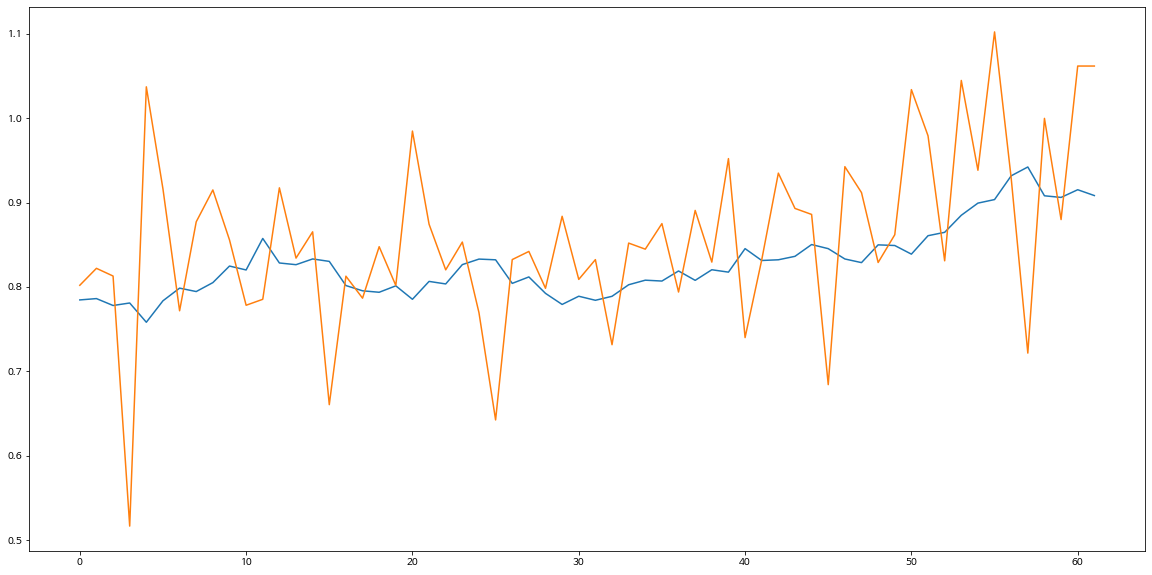

In [25]:
last = pd.DataFrame()

for path in data_list:
    reg_name = path[45:-17]
    data = pd.read_csv(path).drop(['Unnamed: 0'],axis=1)

    batch_size = 512
    timesteps = 7
    n_timeseries = data.shape[1] - 1
    train_length = int(len(data)*0.8)
    val_length = 62
    test_length = 62
    target = "df0_em_g"

    X = np.zeros((len(data), timesteps, data.shape[1]))
    y = np.zeros((len(data), timesteps, 1))


    for i, name in enumerate(list(data.columns[:-1])):
        for j in range(timesteps):
            X[:, j, i] = data[name].shift(timesteps - j - 1).fillna(method="bfill")
            
    for j in range(timesteps):
        y[:, j, 0] = data["df0_em_g"].shift(timesteps - j - 1).fillna(method="bfill")

    prediction_horizon = 1
    target = data["df0_em_g"].shift(-prediction_horizon).fillna(method="ffill").values

    X = X[timesteps:]
    y = y[timesteps:]
    target = target[timesteps:]

    X_train = X[:train_length]
    y_his_train = y[:train_length]
    X_val = X[train_length:train_length+val_length]
    y_his_val = y[train_length:train_length+val_length]
    X_test = X[-val_length:]
    y_his_test = y[-val_length:]
    target_train = target[:train_length]
    target_val = target[train_length:train_length+val_length]
    target_test = target[-val_length:]

    X_train_t = torch.Tensor(X_train)
    X_val_t = torch.Tensor(X_val)
    X_test_t = torch.Tensor(X_test)
    y_his_train_t = torch.Tensor(y_his_train)
    y_his_val_t = torch.Tensor(y_his_val)
    y_his_test_t = torch.Tensor(y_his_test)
    target_train_t = torch.Tensor(target_train)
    target_val_t = torch.Tensor(target_val)
    target_test_t = torch.Tensor(target_test)
    model = DARNN(X_train.shape[2], 128, 128, X_train.shape[1]).cuda() 
    opt = torch.optim.Adam(model.parameters(), lr=0.001)

    epoch_scheduler = torch.optim.lr_scheduler.StepLR(opt, 20, gamma=0.9)

    from torch.utils.data import TensorDataset, DataLoader
    data_train_loader = DataLoader(TensorDataset(X_train_t, y_his_train_t, target_train_t), shuffle=True, batch_size=16)
    data_val_loader = DataLoader(TensorDataset(X_val_t, y_his_val_t, target_val_t), shuffle=False, batch_size=16)
    data_test_loader = DataLoader(TensorDataset(X_test_t, y_his_test_t, target_test_t), shuffle=False, batch_size=16)

    #학습
    from sklearn.metrics import mean_squared_error, mean_absolute_error

    # early_stopping object의 초기화
    # early_stopping = EarlyStopping(patience = 20, verbose = True)

    epochs = 300
    loss = nn.MSELoss()
    patience = 15 
    min_val_loss = 9999
    counter = 0
    for i in range(epochs):
        mse_train = 0
        for batch_x, batch_y_h, batch_y in data_train_loader :
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            opt.zero_grad()
            y_pred = model(batch_x, batch_y_h)
            y_pred = y_pred.squeeze(1)
            l = loss(y_pred, batch_y)
            l.backward()
            mse_train += l.item()*batch_x.shape[0]
            opt.step()
        epoch_scheduler.step()
        with torch.no_grad():
            mse_val = 0
            preds = []
            true = []
            for batch_x, batch_y_h, batch_y in data_val_loader:
                batch_x = batch_x.cuda()
                batch_y = batch_y.cuda()
                batch_y_h = batch_y_h.cuda()
                output = model(batch_x, batch_y_h)
                output = output.squeeze(1)
                preds.append(output.detach().cpu().numpy())
                true.append(batch_y.detach().cpu().numpy())
                mse_val += loss(output, batch_y).item()*batch_x.shape[0]
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        
        if min_val_loss > mse_val**0.5:
            min_val_loss = mse_val**0.5
            print("Saving...")
            torch.save(model.state_dict(), "./"+reg_name+"_best_darnn_temp.pt")
            counter = 0
        else: 
            counter += 1
        
        if counter == patience:
            break
        print("Iter: ", i, "train: ", (mse_train/len(X_train_t))**0.5, "val: ", (mse_val/len(X_val_t))**0.5)
        
        mse = mean_squared_error(true, preds)
        mae = mean_absolute_error(true, preds)
        print("mse: ", mse, "mae: ", mae)
        # plt.figure(figsize=(20, 10))
        # plt.plot(preds)
        # plt.plot(true)
        # plt.ioff()
        # plt.savefig('./'+reg_name+'_valid.png')

        # early_stopping(mse_val, model)

        # if early_stopping.early_stop:
        #     print("Early stopping")
        #     break

    model.load_state_dict(torch.load("./"+reg_name+"_best_darnn_temp.pt"))

    with torch.no_grad():
        mse_val = 0
        preds = []
        true = []
        for batch_x, batch_y_h, batch_y in data_test_loader:
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            batch_y_h = batch_y_h.cuda()
            output = model(batch_x, batch_y_h)
            preds.append(output.detach().cpu().numpy())
            true.append(batch_y.detach().cpu().numpy())
            mse_val += loss(output, batch_y).item()*batch_x.shape[0]
    preds = np.concatenate(preds)
    true = np.concatenate(true)
        
    plt.figure(figsize=(20, 10))
    plt.plot(preds)
    plt.plot(true)
    plt.ioff()
    plt.savefig('./'+reg_name+'_test.png')
    #plt.show()
    #orange = 실제
    #blue = 예측

    test_ds = data_val_loader, data_test_loader

    #예측 
    preds = []

    for i in next(iter(test_ds)):
        enc,dec,true = i
        pred = model(enc.cuda(),dec.cuda())
        pred = pred.squeeze(1)
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)
    
    last[reg_name] = preds
    
    # preds.shape,pd.Series(preds).plot()
# last.to_csv('./clip_last_per_reg.csv')

In [19]:
last

,한림읍
0,0.755396
1,0.766408
2,0.744948
3,0.765393
4,0.758380
5,0.744536
6,0.756247
7,0.744176
8,0.727251
9,0.740564


In [ ]:
scaler_list = sorted(glob.glob('C:/Users/cahcahcha/Downloads/emg_minmax_scaler/*')) # 경로변경 필요
scaler_list

['C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\건입동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\구좌읍scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\남원읍scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\노형동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\대륜동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\대정읍scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\대천동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\도두동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\동홍동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\봉개동scaler_noclip_split_emg_minmax.pkl',
 'C:/Users/cahcahcha/Downloads/emg_minmax_scaler\\삼도1동scaler_noclip_split_emg_minmax.pkl',
 'C:/User

In [ ]:
# 역스케일러
import joblib 
import math 

last = pd.read_csv('./clip_last_per_reg.csv')

d = pd.DataFrame()

data_list = sorted(data_list)
for i in range(len(data_list)):
    reg_name = data_list[i][45:-17]

    file_name = scaler_list[i]
    obj = joblib.load(file_name) 
    after_scaler = obj.inverse_transform(np.array(last[reg_name]).reshape(-1, 1))
    after_scaler = after_scaler.squeeze(1)
    last[reg_name] = after_scaler
    
    after_scaler = [round(i,1) for i in after_scaler]
    d[reg_name] = after_scaler
    
    # r.loc[len(r)] = [reg_name, sum(after_scaler[:31]),sum(after_scaler[31:])]
    
# r.to_csv('./darnn_result.csv')
# d.to_csv('./dates_darnn_result.csv')

C:\Users\cahcahcha\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\cahcahcha\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\cahcahcha\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
C:\Users\cahcahcha\anaconda3\lib\site-packages\sklearn\base.py:310: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.22.2.post1 when using version 0.24.1. This might lead to b